# Analysis of a small game

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import nashpy as nash

plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['CMU Serif']
plt.rc('axes', unicode_minus=False)
plt.rcParams['text.usetex'] = True

Computation of utilities for one festival:

In [2]:
def compute_utilities(strategy_1, strategy_2, n_players, n_concerts, n_lines, n_timesteps, utilities):

    front_row_utility = utilities[0]
    back_row_utility = utilities[1]
    same_row_utility = utilities[2]
    start_utility = utilities[3]
    waiting_utility = utilities[4]

    utilities = np.zeros(n_players)
    strategies = [strategy_1, strategy_2]

    positions_which_concert = np.zeros(n_players)
    positions_which_line = np.ones(n_players, dtype = float) * np.mean(sum(range(1,n_lines + 1))) # assume mean line value for every player in first concert
    time_spent_at_current_stage = np.zeros(n_players)

    # iterate through time
    for time in range(n_timesteps):
        
        # update positions
        for player in range(n_players):

            player_strategy = strategies[player]
            
            # check if player will move
            moved = 0
            for i in range(len(player_strategy)):

                if (player_strategy[i] == time):
                    positions_which_concert[player] = i + 1 # eg player_strategy[i] = 0 means go to concert 1 at time 0. 
                    time_spent_at_current_stage[player] = 0
                    moved = 1

            # increase time at current stage
            if(not moved):
                time_spent_at_current_stage[player] = time_spent_at_current_stage[player] + 1

        # check which line each player is at
        for concert in range(n_concerts):
            players = list(np.where(positions_which_concert == concert)[0])
           
            if(len(players) > 0):

                count_players = 0
           
                for time_spent in range(int(max(time_spent_at_current_stage[players])),-1, -1):
                    players_who_spent_this_time = list(np.where(time_spent_at_current_stage == time_spent)[0])
                    players_correct_time_and_stage = list(np.intersect1d(players, players_who_spent_this_time))
               
                    n_players_same_time = len(players_correct_time_and_stage)
                    
                    if (n_players_same_time > 0):
                        # assuming two players
                        if (n_players_same_time == 1 and count_players == 0):
                            positions_which_line[players_correct_time_and_stage] = front_row_utility
                            count_players += 1
                        elif (n_players_same_time == 1 and count_players == 1):
                            positions_which_line[players_correct_time_and_stage] = back_row_utility
                        else:
                            positions_which_line[players_correct_time_and_stage] = same_row_utility
    
        # check current concert and update utilities for each player
        for player in range(n_players):
            if (positions_which_concert[player] == time):
                if(time == 0):
                    utilities[player] += start_utility
                else:
                    utilities[player] += positions_which_line[player]
            else:
                utilities[player] += waiting_utility

    return utilities


Simulation of one festival to obtain normal form:

In [9]:
def simulate_festival(utilities_param):
    n_concerts = 3
    n_lines = 2
    n_players = 2
    timesteps = list(range(n_concerts))
    n_timesteps = n_concerts

    actions = list(itertools.combinations_with_replacement(timesteps, n_concerts - 1))
    actions.pop(1)
    actions.pop(-1)
    print(actions)
    print()
    n_actions = len(actions)

    utilities_normal_form_P1 = np.zeros((n_actions, n_actions))
    utilities_normal_form_P2 = np.zeros((n_actions, n_actions))

    for i in range(n_actions):
        for j in range(n_actions):
            utilities = compute_utilities(actions[i], actions[j], n_players, n_concerts, n_lines, n_timesteps, utilities_param)
            utilities_normal_form_P1[i][j] = utilities[0]
            utilities_normal_form_P2[i][j] = utilities[1]

    print("Normal form P1")
    print(utilities_normal_form_P1)
    print()
    print("Normal form P2")
    print(utilities_normal_form_P2)

    return utilities_normal_form_P1, utilities_normal_form_P2


Compute evolutionary stable strategies (pure ones)

[(0, 0), (0, 2), (1, 1), (1, 2)]

Normal form P1
[[ 0.  8.  8.  8.]
 [ 9.  3.  9. 11.]
 [ 1. 11.  3. 11.]
 [12.  4. 12.  6.]]

Normal form P2
[[ 0.  9.  1. 12.]
 [ 8.  3. 11.  4.]
 [ 8.  9.  3. 12.]
 [ 8. 11. 11.  6.]]

Equilibria
[[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.35714286  0.35714286  0.          0.28571429]
 [-0.          0.26923077  0.42307692  0.30769231]
 [ 0.02873563  0.3045977   0.36781609  0.29885057]]


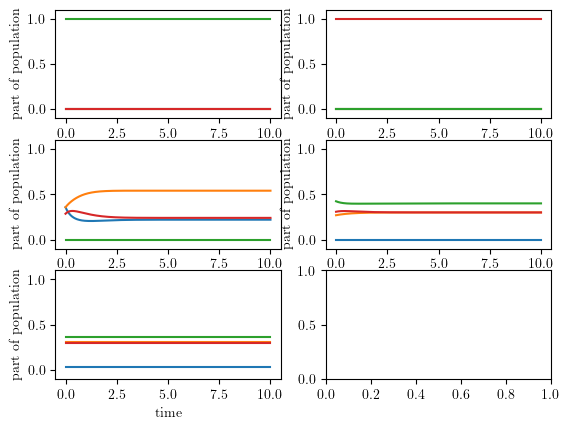

In [55]:
# parameters
front_row_utility = 10
back_row_utility = 0
same_row_utility = 2
start_utility = 2
waiting_utility = -1
utilities_param = [front_row_utility, back_row_utility, same_row_utility, start_utility, waiting_utility]
n_actions = 4

# simulate to get normal form
utilities_normal_form_P1, utilities_normal_form_P2 = simulate_festival(utilities_param)

# compute nash equilibria
game = nash.Game(utilities_normal_form_P1, utilities_normal_form_P2)
equilibria = game.support_enumeration()
n_eq = sum(1 for _ in equilibria)

equilibria = game.support_enumeration() # reset generator
equilibria_start = np.zeros((5, 4))
eq_counter = 0
for eq in equilibria:
    equilibria_start[eq_counter,:] = eq[0]
    eq_counter += 1

print()
print("Equilibria")
print(equilibria_start)

# evolutionary simulation
initial_pop = np.array([0.25, 0.25, 0.25, 0.25])
time = np.linspace(0, 10, 1000)

# plot evolutionary result
n_rows_plot = int(np.floor(n_eq/2) + 1)

fig, axes = plt.subplots(n_rows_plot,2)

labels = ["que direcly for concert 2", "que for concert 1, watch 1 and 2", "watch concert 0, then que for 2", "watch all concerts"]

eq_counter = 0
for i in range(0, n_rows_plot):
    for j in range(0,2):

        initial_pop = equilibria_start[eq_counter,:]
        eq_counter += 1
        populations = game.replicator_dynamics(y0 = initial_pop, timepoints = time).T

        for k in range(n_actions):
            
            axes[i,j].plot(time, populations[k], label = labels[k])
            #axes[i,j].legend(loc = "lower left")
            axes[i,j].set_ylabel(r'part of population')
            axes[i,j].set_xlabel(r'time')
            axes[i,j].set_ylim([-0.1,1.1])

        if (eq_counter > n_eq - 1):
            break
        
plt.show()


[(0, 0), (0, 2), (1, 1), (1, 2)]

Normal form P1
[[ 0.  8.  8.  8.]
 [ 9.  3.  9. 11.]
 [ 1. 11.  3. 11.]
 [12.  4. 12.  6.]]

Normal form P2
[[ 0.  9.  1. 12.]
 [ 8.  3. 11.  4.]
 [ 8.  9.  3. 12.]
 [ 8. 11. 11.  6.]]
(array([0., 0., 1., 0.]), array([0., 0., 0., 1.]))
(array([0., 0., 0., 1.]), array([0., 0., 1., 0.]))
(array([0.35714286, 0.35714286, 0.        , 0.28571429]), array([-0.        ,  0.26923077,  0.42307692,  0.30769231]))
(array([-0.        ,  0.26923077,  0.42307692,  0.30769231]), array([0.35714286, 0.35714286, 0.        , 0.28571429]))
(array([0.02873563, 0.3045977 , 0.36781609, 0.29885057]), array([0.02873563, 0.3045977 , 0.36781609, 0.29885057]))

Equilibria
[[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.35714286  0.35714286  0.          0.28571429]
 [-0.          0.26923077  0.42307692  0.30769231]
 [ 0.02873563  0.3045977   0.36781609  0.29885057]]


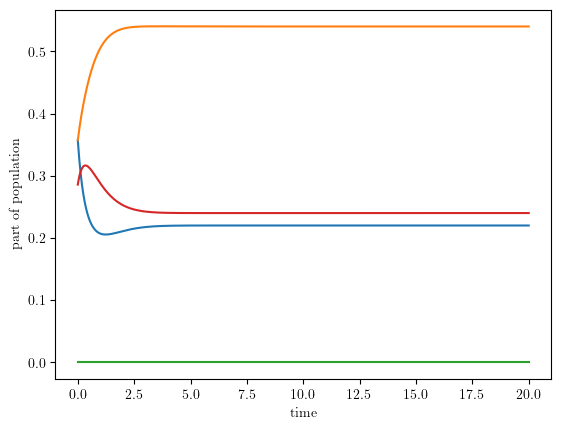

In [65]:
front_row_utility = 10
back_row_utility = 0
same_row_utility = 2
start_utility = 2
waiting_utility = -1
utilities_param = [front_row_utility, back_row_utility, same_row_utility, start_utility, waiting_utility]
n_actions = 4

# simulate to get normal form
utilities_normal_form_P1, utilities_normal_form_P2 = simulate_festival(utilities_param)

# compute nash equilibria
game = nash.Game(utilities_normal_form_P1, utilities_normal_form_P2)
equilibria = game.support_enumeration()
n_eq = sum(1 for _ in equilibria)

equilibria = game.support_enumeration() # reset generator
equilibria_start = np.zeros((5, 4))
eq_counter = 0
for eq in equilibria:
    print(eq)
    equilibria_start[eq_counter,:] = eq[0]
    eq_counter += 1

print()
print("Equilibria")
print(equilibria_start)

# evolutionary simulation
initial_pop = np.array([0.25, 0.25, 0.25, 0.25])
initial_pop = equilibria_start[2,:]
time = np.linspace(0, 20, 1000)
populations = game.replicator_dynamics(y0 = initial_pop, timepoints = time).T

# plot evolutionary result
fig, axes = plt.subplots(1,1)

labels = ["que direcly for concert 2", "que for concert 1, watch 1 and 2", "watch concert 0, then que for 2", "watch all concerts"]

for k in range(n_actions):
    
    axes.plot(time, populations[k], label = labels[k])
    #axes[i,j].legend(loc = "lower left")
    axes.set_ylabel(r'part of population')
    axes.set_xlabel(r'time')
    #axes.set_ylim([-0.1,1.1])


plt.show()